In [1]:
# importing useful libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# loading in the dataset
credit_card_df = pd.read_csv('../input/creditcardfraud/creditcard.csv')
print(credit_card_df.shape)
credit_card_df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# 27 most important features according to our EDA
cols = ['V'+str(i) for i in range(1, 29) if i != 25]
print(cols)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V26', 'V27', 'V28']


In [4]:
# selecting the 27 most important features according to our EDA 
df = credit_card_df.copy()

y = df.pop('Class') # selecting the target variable

X = df
X.shape

(284807, 30)

In [5]:
val_count = y.value_counts()
weights = dict(1 / val_count) # to be used as class weights
weights

{0: 3.51722561243691e-06, 1: 0.0020325203252032522}

In [6]:
scale_pos_weight = val_count / val_count[1]
scale_pos_weight

0    577.876016
1      1.000000
Name: Class, dtype: float64

## <center>Cost matrix for fraud detection</center>

||Actual Positive|Actual Negative|
|:-:|:-:|:-:|
|**Predicted Positive**|administrative cost|administrative cost|
|**Predicted Negative**|transactional cost|0|

### *see [this article](https://towardsdatascience.com/fraud-detection-with-cost-sensitive-machine-learning-24b8760d35d9) for more about cost sensitive machine learning for fraud detection*

In [7]:
admin_cost = 2.5

### our choice of using 2.5euros as the administartive cost because it seems to be the best for our problem as suggested by [this paper](https://www.researchgate.net/publication/262390835_Cost_Sensitive_Credit_Card_Fraud_Detection_Using_Bayes_Minimum_Risk)

## Also, implementing cost sensitive models for sklearn's classifier is challenging. It is as good as creating a new model from the scratch. For simplicity, we will not penalize our model of True Positives (although, the cost matrix suggests we should penalize it for true positives). This will mean that we are only penalizing MISCLASSIFICATIONS (trying to minimize costs due to misclassification and not cost in general).

In [8]:
# defining a function to calculate cost savings
def cost_saving(ytrue, ypred, amount):
    fp = np.sum((ytrue == 0) & (ypred == 1))
    cost = np.sum(fp*admin_cost) + np.sum((amount[(ytrue == 1) & (ypred == 0)]))
    max_cost = np.sum((amount[(ytrue == 1)]))
    savings = 1 - (cost/max_cost)
    
    return savings

In [9]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

In [10]:
# defining a function to calculate cost saving per fold (splits) of our cv
def cost_saving_per_split(scores, x, y, cv_object):
    results = []
    for i, (_, test_ind) in zip(range(cv_object.n_splits), cv_object.split(x, y)):
        ypred = scores['estimator'][i].predict(x[test_ind])
        ytrue = y[test_ind]
        amount = df['Amount'].values[test_ind]
        results.append(cost_saving(ytrue, ypred, amount))
        
    return results

In [11]:
# defining a function to return a dataframe of metrics results for each fold in our cv
def get_metric_scores(scores, x, y=y, cv_object=cv):
    ind = ['split_'+str(n) for n in range(1, cv_object.n_splits+1)]
    
    scores_df = pd.DataFrame(index=ind)
    
    scores_df['f1_score'] = scores['test_f1']
    scores_df['auc_pr'] = scores['test_average_precision']
    scores_df['cost_savings'] = cost_saving_per_split(scores, x, y, cv_object)

    return scores_df

In [12]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, cols=cols):
        self.cols = cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return np.array(X[self.cols])

        elif isinstance(X, pd.Series):
            return np.array(X[self.cols]).reshape(1, -1)

        elif isinstance(X, np.ndarray):
            self.cols_ind = [int(col[1:]) for col in self.cols]
            if len(X.shape) == 1: # if one dimensional array
                return X[self.cols_ind].reshape(1, -1)
            return X[:, self.cols_ind]

        else:
            raise TypeError('expected input type to be any of pd.Series, pd.DataFrame or np.ndarray but got {}'.format(type(X)))

In [13]:
fraud_sensitive_model = XGBClassifier(random_state=1)
scaler = StandardScaler()
col_select = ColumnSelector()

fraud_sensitive_pipe = Pipeline([('col_seclect', col_select), ('scaler', scaler), \
                                  ('model', fraud_sensitive_model)])

fraud_sensitive_scores = cross_validate(fraud_sensitive_pipe, np.array(X), y, \
                            scoring=['f1', 'average_precision'], cv=cv, n_jobs=-1, verbose=1, \
                                        return_estimator=True, error_score='raise')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  2.6min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.7min finished


In [14]:
fraud_sensitive_results = get_metric_scores(fraud_sensitive_scores, np.array(X))
fraud_sensitive_results

,f1_score,auc_pr,cost_savings
split_1,0.854626,0.814355,0.727503
split_2,0.877193,0.869953,0.755890
split_3,0.888889,0.893029,0.726574
split_4,0.837838,0.840851,0.567046


In [15]:
fraud_sensitive_results.mean()

f1_score        0.864636
auc_pr          0.854547
cost_savings    0.694253
dtype: float64

In [16]:
# setting class weight
fraud_sensitive_model2 = XGBClassifier(random_state=1, scale_pos_weight=scale_pos_weight[0])
scaler2 = StandardScaler()
col_select2 = ColumnSelector()

fraud_sensitive_pipe2 = Pipeline([('col_seclect', col_select2), ('scaler', scaler2), \
                                  ('model', fraud_sensitive_model2)])

fraud_sensitive_scores2 = cross_validate(fraud_sensitive_pipe2, np.array(X), y, \
                            scoring=['f1', 'average_precision'], cv=cv, n_jobs=-1, verbose=1, \
                                        return_estimator=True, error_score='raise')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  2.8min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.8min finished


In [17]:
fraud_sensitive_results2 = get_metric_scores(fraud_sensitive_scores2, np.array(X))
fraud_sensitive_results2

,f1_score,auc_pr,cost_savings
split_1,0.815126,0.820556,0.725581
split_2,0.884120,0.873954,0.757186
split_3,0.882096,0.885420,0.708944
split_4,0.858407,0.841433,0.590109


In [18]:
fraud_sensitive_results2.mean()

f1_score        0.859937
auc_pr          0.855341
cost_savings    0.695455
dtype: float64

In [19]:
sample_weights = np.array([df['Amount'][ind] if fraud else admin_cost for ind, fraud in enumerate(y)])

In [20]:
scaler3 = StandardScaler()
col_select3 = ColumnSelector()
cost_sensitive_model = XGBClassifier(random_state=1)

cost_sensitive_pipe = Pipeline([('col_select', col_select3), ('scaler', scaler3), \
                                ('model', cost_sensitive_model)])

cost_sensitive_scores = cross_validate(cost_sensitive_pipe, X, y, verbose=1, \
                        scoring=['f1', 'average_precision'], cv=cv, n_jobs=-1, return_estimator=True, \
                          fit_params={'model__sample_weight': sample_weights}, error_score='raise')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  2.7min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.8min finished


In [21]:
cost_sensitive_results = get_metric_scores(cost_sensitive_scores, np.array(X))
cost_sensitive_results

,f1_score,auc_pr,cost_savings
split_1,0.838428,0.804608,0.724814
split_2,0.884120,0.874974,0.757186
split_3,0.871111,0.900661,0.817148
split_4,0.849558,0.829047,0.713988


In [22]:
cost_sensitive_results.mean()

f1_score        0.860804
auc_pr          0.852323
cost_savings    0.753284
dtype: float64

### we now see that cost sensitive example dependent XGBoost model is the best for our dataset.

## Calibration

### Since we wish to report probabilities also, we need to calibrate it and maybe it can also improve results. XGBoost's probability is often not calibrated, we will now move to calibrating ours.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1)

In [24]:
sample_weights2 = np.array([X_train['Amount'].iloc[ind] if fraud else admin_cost for ind, fraud in \
                            enumerate(y_train)])

In [25]:
from sklearn.calibration import calibration_curve

In [26]:
def reliability_plot(model, x, y):
    # predict probabilities
    probs = model.predict_proba(x)[:, 1]
    # reliability diagram
    fop, mpp = calibration_curve(y, probs, normalize=True)
    # plot perfectly calibrated
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot calibrated reliability
    plt.plot(mpp, fop, marker='.')
    plt.title('reliability plot')
    plt.xlabel('mean_predicted_probability')
    plt.ylabel('frequency_of_positives')
    plt.show()

In [27]:
scaler4 = StandardScaler()
col_select4 = ColumnSelector()
cost_sensitive_model2 = XGBClassifier(random_state=1)

cost_sensitive_pipe2 = Pipeline([('col_select', col_select4), ('scaler', scaler4), \
                                ('model', cost_sensitive_model2)])

cost_sensitive_pipe2.fit(X_train, y_train, model__sample_weight=sample_weights2);

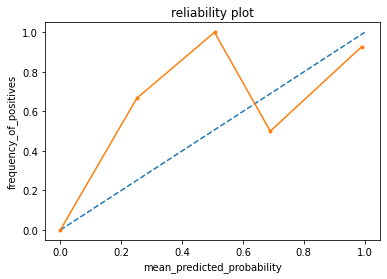

In [28]:
reliability_plot(cost_sensitive_pipe2, X_test, y_test)

### we see that our model is not well calibrated

In [29]:
from sklearn.calibration import CalibratedClassifierCV

### calibrating using sigmoid method

In [30]:
scaler5 = StandardScaler()
col_select5 = ColumnSelector()
cost_sensitive_model3 = XGBClassifier(random_state=1)

cost_sensitive_pipe3 = Pipeline([('col_select', col_select5), ('scaler', scaler5), \
                                ('model', cost_sensitive_model3)])

cost_sensitive_pipe3.fit(X_train, y_train, model__sample_weight=sample_weights2)

calibrated = CalibratedClassifierCV(cost_sensitive_pipe3, method='sigmoid', cv='prefit')

calibrated.fit(X_train, y_train);

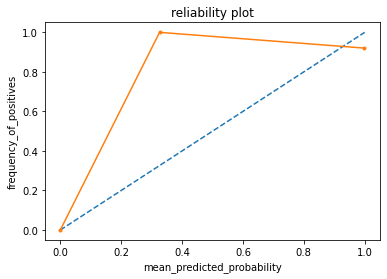

In [31]:
reliability_plot(calibrated, X_test, y_test)

### calibrating using isotonic method

In [32]:
scaler6 = StandardScaler()
col_select6 = ColumnSelector()
cost_sensitive_model4 = XGBClassifier(random_state=1)

cost_sensitive_pipe4 = Pipeline([('col_select', col_select6), ('scaler', scaler6), \
                                ('model', cost_sensitive_model4)])

cost_sensitive_pipe4.fit(X_train, y_train, model__sample_weight=sample_weights2)

calibrated2 = CalibratedClassifierCV(cost_sensitive_pipe4, method='isotonic', cv='prefit')
calibrated2.fit(X_train, y_train);

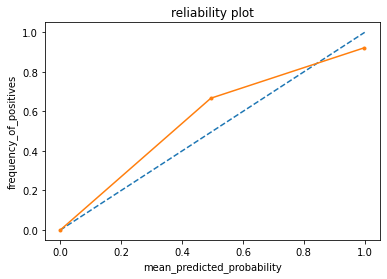

In [33]:
reliability_plot(calibrated2, X_test, y_test)

### We now see that isotonic calibration is the best for our model.

## Checking for best threshold

## Evaluating calibrated cost sensitive xgboost

In [34]:
from sklearn.metrics import precision_recall_curve

In [35]:
scaler7 = StandardScaler()
col_select7 = ColumnSelector()
cost_sensitive_model5 = XGBClassifier(random_state=1)

cost_sensitive_pipe5 = Pipeline([('col_select', col_select7), ('scaler', scaler7), \
                                ('model', cost_sensitive_model5)])

cost_sensitive_pipe5.fit(X_train, y_train, model__sample_weight=sample_weights2)

calibrate3 = CalibratedClassifierCV(cost_sensitive_pipe5, method='isotonic', cv='prefit')
calibrate3.fit(X_train, y_train)

# predict probabilities
probs = calibrate3.predict_proba(X_test)[:, 1]

precision, recall, threshold = precision_recall_curve(y_test, probs)

In [36]:
f1 = (2*precision*recall) / (precision+recall)
best_ind = np.argmax(f1)
print('best f1_score is {}'.format(f1[best_ind]))
best_threshold = threshold[best_ind]
best_threshold

best f1_score is 0.896265560165975


0.46393975615501404

In [37]:
threshold0_5 = threshold[threshold <= 0.5][-1]
threshold0_5

0.4930618107318878

In [38]:
ind_0_5 = len(threshold[threshold <= 0.5])
ind_0_5

12

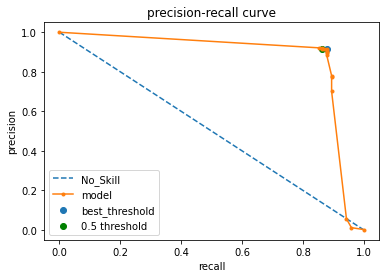

In [39]:
plt.plot([0, 1], [1, 0], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.scatter(recall[best_ind], precision[best_ind])
plt.scatter(recall[ind_0_5], precision[ind_0_5], color='g')
plt.legend(['No_Skill', 'model', 'best_threshold', '0.5 threshold'])
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision-recall curve')
plt.show()

### We now see that threshold of 0.5 is a good approximation.

## Business Analysis

In [40]:
from sklearn.metrics import average_precision_score, recall_score, accuracy_score, precision_score

In [41]:
import time

# defining a function to return a dataframe of metrics results for each fold in our cv
def get_calibrated_metric_scores(model_pipe, x, y=y, cv_object=cv):
    probs = []
    ytests = []
    amounts = []
    
    for i, (train_ind, test_ind) in zip(range(cv_object.n_splits), cv_object.split(x, y)):
        to = time.time()
        
        xtrain = x.loc[train_ind]
        xtest = x.loc[test_ind]
        ytrain = y[train_ind]
        ytest = y[test_ind]

        sample_weights = np.array([xtrain['Amount'][ind] if fraud else admin_cost for ind, fraud \
                                   in ytrain.items()])
        
        amount = xtest['Amount'].values
        
        model_pipe.fit(xtrain, ytrain, model__sample_weight=sample_weights)
        
        calibrate = CalibratedClassifierCV(model_pipe, method='isotonic', cv='prefit')
        calibrate.fit(xtrain, ytrain)

        prob = calibrate.predict_proba(xtest)[:, 1]
        
        probs.append(prob)
        ytests.append(ytest.values)
        amounts.append(amount)
        
        print('Done {} of {} =================={}mins'.format(i+1, len(range(cv_object.n_splits)), \
             round((time.time() - to)/60, 1)))
        
    return np.array(ytests), np.array(probs), np.array(amounts)

In [42]:
scaler8 = StandardScaler()
col_select8 = ColumnSelector()
cost_sensitive_model6 = XGBClassifier(random_state=1)

cost_sensitive_pipe6 = Pipeline([('col_select', col_select8), ('scaler', scaler8), \
                                ('model', cost_sensitive_model6)])

In [43]:
ytests, probs, amounts = get_calibrated_metric_scores(cost_sensitive_pipe6, X)

Done 1 of 4 ==================0.7mins
Done 2 of 4 ==================0.7mins
Done 3 of 4 ==================0.7mins
Done 4 of 4 ==================0.7mins


In [44]:
ypreds = np.array([(probs[i] >= 0.5).astype(np.int64) for i in range(ytests.shape[0])])

In [45]:
accuracies = np.array([accuracy_score(ytests[i], ypreds[i]) for i in range(ytests.shape[0])])
print('accuracy_score per split are {}'.format(accuracies))
accuracies.mean()

accuracy_score per split are [0.99945226 0.99960675 0.99966293 0.99957866]


0.999575150903969

In [46]:
precisions = np.array([precision_score(ytests[i], ypreds[i]) for i in range(ytests.shape[0])])
print('precision_score per split are {}'.format(precisions))
precisions.mean()

precision_score per split are [0.86842105 0.92035398 0.95412844 0.93457944]


0.9193707286379432

In [47]:
f1s = np.array([f1_score(ytests[i], ypreds[i]) for i in range(ytests.shape[0])])
print('f1_score per split are {}'.format(f1s))
f1s.mean()

f1_score per split are [0.83544304 0.88135593 0.89655172 0.86956522]


0.8707289779268271

In [48]:
auc_prs = np.array([average_precision_score(ytests[i], probs[i]) for i in range(ytests.shape[0])])
print('auc_pr per split are {}'.format(auc_prs))
auc_prs.mean()

auc_pr per split are [0.69977079 0.80805466 0.81074358 0.7764121 ]


0.7737452824683015

In [49]:
cost_saved = np.array([cost_saving(ytests[i], ypreds[i], amounts[i]) for i in range(ytests.shape[0])])
print('cost saved per split are {}'.format(cost_saved))
cost_saved.mean() # benefit of using our model

cost saved per split are [0.72665202 0.7568327  0.81861841 0.72151261]


0.7559039341041671

In [50]:
recalls = np.array([recall_score(ytests[i], ypreds[i]) for i in range(ytests.shape[0])])
print('recall per split are {}'.format(recalls))
recalls.mean()

recall per split are [0.80487805 0.84552846 0.84552846 0.81300813]


0.8272357723577236

In [51]:
specificity = np.array([recall_score(ytests[i], ypreds[i], pos_label=0) for i in \
               range(ytests.shape[0])])
print('specificity per split are {}'.format(specificity))
specificity.mean()

specificity per split are [0.99978897 0.99987338 0.99992966 0.99990152]


0.9998733799769153

In [52]:
volumes = np.array([amounts[i].sum() for i in range(ytests.shape[0])] )
print('volume per split in euros are {}'.format(volumes))
volumes.mean()

volume per split in euros are [6322617.22 6351475.49 6212989.53 6275507.77]


6290647.5025

In [53]:
tp = recalls.mean() * (val_count[1] / 4) 
fn = (1 - recalls.mean()) * (val_count[1] / 4) 
fp = (1 - specificity.mean()) * round(val_count[0] / 4) 
tn = specificity.mean() * round(val_count[0] / 4) 

In [54]:
assert tp + tn + fp + fn == len(ytests[0])

In [55]:
print('average tp is {}'.format(round(tp)))
print('average fp is {}'.format(round(fp)))
print('average tn is {}'.format(round(tn)))
print('average fn is {}'.format(round(fn)))

average tp is 102.0
average fp is 9.0
average tn is 71070.0
average fn is 21.0


In [56]:
declined_transactions =  (tp+fp) / len(ytests[0])
approved_transactions = (fn+tn) / len(ytests[0])
print('percentage of declined transaction is {} which is equivalent to {}euros'.format(\
       100*declined_transactions, declined_transactions*volumes.mean()))
print()
print('percentage of approved transaction is {} which is equivalent to {}euros'.format(\
       100*approved_transactions, approved_transactions*volumes.mean()))

percentage of declined transaction is 0.15554341819167858 which is equivalent to 9784.68815177796euros

percentage of approved transaction is 99.84445658180833 which is equivalent to 6280862.814348223euros


In [57]:
print('{} percentage of declined transaction were actually fraudulent which is equivalent to {}euros'.format(\
        100*tp/(tp+fp), (volumes.mean()*tp/len(ytests[0]))))
print()
print('{} percentage of approved transaction were actually not fraudulent which is equivalent to {}euros'.format(\
        100*tn/(tn+fn), (volumes.mean()*tn/len(ytests[0]))))

91.8735687403671 percentage of declined transaction were actually fraudulent which is equivalent to 8989.542195154281euros

99.97010883898179 percentage of approved transaction were actually not fraudulent which is equivalent to 6278985.391531053euros


In [58]:
ytests[0].shape

(71202,)

### All of these metrics are cross validated and they are for 71202 transactions which is the size of 1 fold of our splits.